## 2D Simulations; Exact Hydrodynamics of Active Exclusion Processes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

Let's define some functions from Sections 2,4 of the paper: 
https://arxiv.org/pdf/2307.11673 


In [2]:
def d_s(rho: float):
    alpha = np.pi/2 - 1
    if rho<=1.0 and rho>=0.0:
        return (1-rho)*(1-alpha*rho + ((alpha*(2*alpha-1))/(2*alpha+1))*rho**2 )
    elif rho>= 1.0:
        print('density exceeding 1!!!!')
        return 0.0
    elif rho<=0.0:
        print('negative probs!!!!')
        return 0.0
    
def d_s_arr(rho_arr):
    alpha = np.pi/2 - 1
    return (1-rho_arr)*(1-alpha*rho_arr + ((alpha*(2*alpha-1))/(2*alpha+1))*rho_arr**2 )
    
def D(rho: float):
    return (1-d_s(rho))/rho

def s(rho: float):
    return (1-d_s(rho))/rho - 1

def s_arr(rho):
    return (np.ones(rho.shape)-d_s_arr(rho))/rho - np.ones(rho.shape)

def Q_diff(rho_1: float, rho_2: float):
    rho_avg = (rho_1 + rho_2 )/2
    alpha = np.pi/2 - 1
    beta = (alpha*(2*alpha-1))/(2*alpha+1)

    dQ_drho = ((alpha+1) - (alpha+beta)*rho_avg + beta*rho_avg**2)/(d_s(rho_avg))
    return dQ_drho*(rho_1 - rho_2)

def Q_diff_vectorized(rho_1, rho_2):
    rho_avg = (rho_1 + rho_2) / 2
    alpha = np.pi / 2 - 1
    beta = alpha * (2 * alpha - 1) / (2 * alpha + 1)

    # Calculate dQ_drho in a vectorized way
    dQ_drho = ((alpha + 1) - (alpha + beta) * rho_avg + beta * rho_avg**2) / d_s_arr(rho_avg)
    return dQ_drho * (rho_1 - rho_2)

Next, some useful methods for calculating various functions and functionals of $f_{ijk}$

Next, we write a class for the field $f(\mathbf{x}, \theta)$:

In [55]:
class f:
    def __init__(self, N_x1, N_x2, N_theta, D_E=0.25, v_0=20.0, D_O=1.0, L_x1=1.0, L_x2=1.0) -> None:

        self.L_x1 = L_x1
        self.N_x1 = N_x1
        self.L_x2 = L_x2
        self.N_x2 = N_x2
        self.N_theta = N_theta

        self.delta_x1 = L_x1/N_x1
        self.delta_x2 = L_x2/N_x2
        self.delta_theta = 2*np.pi/N_theta
        self.t=0.0

        self.D_E = D_E
        self.v_0 = v_0
        self.D_O = D_O

        self.l_p = v_0/D_O
        self.l_D = np.sqrt(D_E/D_O)
        self.Pe = self.l_p/self.l_D
        self.l = self.l_D/np.sqrt(L_x1*L_x2)

        #add potential
        #self.V = V
        #self.V_diff = (self.V(self.delta_x * np.arange(1, self.N_x)) - self.V(self.delta_x * np.arange(self.N_x - 1))) / self.delta_x

        self.f = np.zeros((N_x1, N_x2, N_theta))
        self.calc_time = 0.0
        
        self.e1 = np.array([np.cos(k*self.delta_theta) for k in range(self.N_theta)])
        self.e2 = np.array([np.cos(k*self.delta_theta) for k in range(self.N_theta)])

    def rho(self):
        return self.delta_theta * np.sum(self.f, axis=2)
    
    def p_vec(self):
        return self.delta_theta * np.dot(self.f, self.e1), self.delta_theta * np.dot(self.f, self.e2)

    def U_x(self):
        p1_, p2_ = self.p_vec()
        rho_ = self.rho()
        log_f = np.log(self.f)

        diffusion1 = np.diff(log_f, axis=0) / self.delta_x1
        diffusion2 = np.diff(log_f, axis=1) / self.delta_x2

        exclusion1 = np.transpose(np.array([Q_diff_vectorized(rho_[1:, :], rho_[:-1, :]) / self.delta_x1] * self.N_theta), axes=[1,2,0])
        exclusion2 = np.transpose(np.array([Q_diff_vectorized(rho_[:, 1:], rho_[:, :-1]) / self.delta_x2] * self.N_theta), axes=[1,2,0])

        #TODO: add in potential term
        #factor = (1 - rho_) / d_s_arr(rho_)
        #factor_avg = 0.5 * (factor[:-1] + factor[1:])
        #potential = (factor_avg * self.V_diff)[:, None] * np.ones(self.N_theta)

        s_rho = s_arr(rho_) / d_s_arr(rho_)  
        p1_s_rho = p1_ * s_rho  
        p2_s_rho = p2_ * s_rho  
        p1_avg = 0.5 * (p1_s_rho[1:, :] + p1_s_rho[:-1, :])
        p2_avg = 0.5 * (p2_s_rho[:, 1:] + p2_s_rho[:, :-1])
        cos_term = np.cos(np.arange(self.N_theta) * self.delta_theta)
        sin_term = np.sin(np.arange(self.N_theta) * self.delta_theta)
        activity1 = 0.5 * (p1_avg[:, :, None] + cos_term)
        activity2 = 0.5 * (p2_avg[:, :, None] + sin_term)

        U_x1 = -self.D_E*( diffusion1 + exclusion1*0 ) + self.v_0 * activity1*0
        U_x2 = -self.D_E*( diffusion2 + exclusion2*0 ) + self.v_0 * activity2*0
        return U_x1, U_x2
    
    def U_theta(self):
        log_f = np.log(self.f)
        angular_diffusion = (np.roll(log_f, shift=-1, axis=2) - log_f) / self.delta_theta
        return -self.D_O * angular_diffusion[:-1, :-1, :]*0
    
    def F_x(self, U_x1, U_x2):
        rho_ = self.rho()
        d_s_rho = d_s_arr(rho_) 

        f_next1 = np.roll(self.f, -1, axis=0)[:-1, :]
        d_s_avg1 = 0.5 * (d_s_rho + np.roll(d_s_rho, shift=-1, axis=0))

        f_next2 = np.roll(self.f, -1, axis=1)[:, :-1]
        d_s_avg2 = 0.5 * (d_s_rho + np.roll(d_s_rho, shift=-1, axis=1))

        upwind_F1 = np.where(U_x1 >= 0, U_x1 * self.f[:-1, :], U_x1 * f_next1)*d_s_avg1[:-1, :][:, :, None]
        upwind_F2 = np.where(U_x2 >= 0, U_x2 * self.f[:, :-1], U_x2 * f_next2)*d_s_avg2[:, :-1][:, :, None]
        
        return upwind_F1, upwind_F2
    
    def F_theta(self, U_theta):
        f_shifted = np.roll(self.f, -1, axis=2)
        upwind_F = U_theta * (self.f[:-1, :-1, :]+f_shifted[:-1, :-1, :]) / 2
        return upwind_F

    def df_dt(self):
        
        U_x1_, U_x2_ = self.U_x()
        U_theta_ = self.U_theta()
        
        a_x1 = np.max(np.abs(U_x1_))
        a_x2 = np.max(np.abs(U_x2_))
        a_theta = np.max(np.abs(U_theta_))
        
        F_x1_, F_x2_ = self.F_x(U_x1_, U_x2_)
        F_theta_ = self.F_theta(U_theta_)
        
        dF_1_dx = -(F_x1_[1:self.N_x1-1, 1:self.N_x2-1, :] - F_x1_[:self.N_x1-2, 1:self.N_x2-1, :]) / self.delta_x1
        dF_2_dx = -(F_x2_[1:self.N_x1-1, 1:self.N_x2-1, :] - F_x2_[1:self.N_x1-1, self.N_x2-2, :]) / self.delta_x2
        dF_theta_dtheta = -(F_theta_[1:self.N_x1-1, 1:self.N_x2-1, :] - np.roll(F_theta_[1:self.N_x1-1, 1:self.N_x2-1, :], +1, axis=2)) / self.delta_theta
        df_dt_ = dF_1_dx + dF_2_dx + dF_theta_dtheta

        return a_x1, a_x2, a_theta, df_dt_

    def update(self):
        self.f[0, :, :] = self.f[-2, :, :]
        self.f[-1, :, :] = self.f[1, :, :]
        self.f[:, 0, :] = self.f[:, -2, :]
        self.f[:, -1, :] = self.f[:, 1, :]
        
        a_x1, a_x2, a_theta, df_dt_ = self.df_dt()
        
        delta_t = min(self.delta_x1/(a_x1*6), self.delta_x2/(a_x2*6), self.delta_theta/(a_theta*6), 0.00001)

        self.f[1:-1, 1:-1, :] += df_dt_*delta_t
        self.t += delta_t

        return delta_t

    def evolve(self, N_t):
        self.t=0.0
        self.history_rho = []
        self.history_p1 = []
        self.history_direction1 = []
        self.history_p2 = []
        self.history_direction2 = []

        for n in range(N_t):
            if n%100==0:
                p1, p2 = self.p_vec()
                rho_ = self.rho()
                self.history_rho.append( self.rho())
                self.history_p1.append(p1)
                self.history_direction1.append(np.divide(p1, rho_))  
                self.history_p2.append(p2)
                self.history_direction2.append(np.divide(p2, rho_))       
            delta_t = self.update()
            self.t += delta_t
    
    def evolve_to_time(self, t, recording_steps):
        self.t=0.0
        self.history_rho = []
        self.history_p1 = []
        self.history_direction1 = []
        self.history_p2 = []
        self.history_direction2 = []

        step = 0.0
        time_since_last_record = 0.0
        while self.t <= t:
            if time_since_last_record >= recording_steps:
                p1, p2 = self.p_vec()
                self.history_rho.append( self.rho())
                self.history_p1.append(p1)
                self.history_direction1.append(np.divide(p1, self.rho()))  
                self.history_p2.append(p2())
                self.history_direction2.append(np.divide(p2, self.rho()))    
                time_since_last_record = 0.0       
            
            delta_t = self.update()
            self.t += delta_t
            time_since_last_record += delta_t
    
    def set_random(self, phi, delta):
        self.f = np.copy(np.add((phi-delta/2)*np.ones((self.N_x1, self.N_x2, self.N_theta)), delta*np.random.rand(self.N_x1, self.N_x2, self.N_theta))*1/(2*np.pi))
        self.f[0, :, :] = self.f[-2, :, :]
        self.f[-1, :, :] = self.f[1, :, :]
        self.f[:, 0, :] = self.f[:, -2, :]
        self.f[:, -1, :] = self.f[:, 1, :]

    def set_gaussian(self):
        N_x1 = self.N_x1  # example value, adjust as needed
        N_x2 = self.N_x2  # example value, adjust as needed
        N_theta = self.N_theta  # example value, adjust as needed

        # Define the center of the Gaussian
        center_x1 = (N_x1 - 1) / 2
        center_x2 = (N_x2 - 1) / 2

        # Create a grid of coordinates for the first two dimensions
        x1 = np.arange(N_x1)
        x2 = np.arange(N_x2)
        X1, X2 = np.meshgrid(x1, x2, indexing="ij")

        # Define Gaussian parameters
        sigma_x1 = N_x1 / 5  # Standard deviation along the x1 dimension
        sigma_x2 = N_x2 / 5  # Standard deviation along the x2 dimension

        # Calculate the Gaussian distribution along the first two axes
        gaussian_2d = np.exp(-(((X1 - center_x1) ** 2) / (2 * sigma_x1 ** 2) +
                            ((X2 - center_x2) ** 2) / (2 * sigma_x2 ** 2))) * 1/(2*np.pi) * 0.8

        # Expand the Gaussian shape along the third dimension
        f = np.repeat(gaussian_2d[:, :, np.newaxis], N_theta, axis=2)
        
        self.f = np.copy(f)

    def phi(self):
        rho_ = self.rho()
        return np.sum(rho_[1:-1, 1:-1])*(self.L_x1*self.L_x2)/((self.N_x1 - 2)*(self.N_x2 - 2))
    

In [56]:
N_x1 = 20
N_x2 = 20
epsilon=0.6
test_f = f(N_x1=N_x1, N_x2=N_x2, N_theta=10)
test_f.set_gaussian()
test_f.rho()
test_f.evolve(N_t=10000)


/var/folders/3q/bs71m3ns1kq5sjlny3rn8t5r0000gn/T/ipykernel_61071/1325945881.py:122: RuntimeWarning: divide by zero encountered in scalar divide
  delta_t = min(self.delta_x1/(a_x1*6), self.delta_x2/(a_x2*6), self.delta_theta/(a_theta*6), 0.00001)
/var/folders/3q/bs71m3ns1kq5sjlny3rn8t5r0000gn/T/ipykernel_61071/1325945881.py:43: RuntimeWarning: invalid value encountered in log
  log_f = np.log(self.f)
/var/folders/3q/bs71m3ns1kq5sjlny3rn8t5r0000gn/T/ipykernel_61071/1325945881.py:71: RuntimeWarning: invalid value encountered in log
  log_f = np.log(self.f)


MovieWriter Pillow unavailable; using Pillow instead.


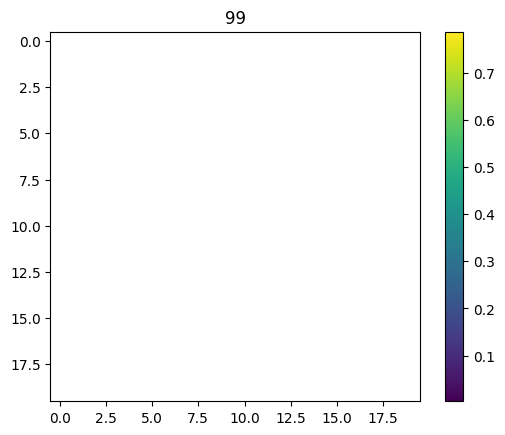

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Assuming 'a' is your list of 2D numpy arrays
# a = [np.random.rand(10, 10) for _ in range(20)]  # Example data for testing

fig, ax = plt.subplots()
heatmap = ax.imshow(test_f.history_rho[0], cmap='viridis')  # Display first frame initially
plt.colorbar(heatmap, ax=ax)

def update(frame):
    """Update the heatmap for each frame."""
    heatmap.set_array(test_f.history_rho[frame])
    ax.set_title(frame)
    return [heatmap]

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(test_f.history_rho), blit=True)

# Display the animation in a notebook
ani.save('animation.gif', writer='Pillow', fps=10)  # Save as mp4 file
plt.show()
